In [82]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline
%aimport ichol_V
%aimport ichol
%aimport simulation
%aimport ichol_adadelta
%aimport ichol_constrain_m
%aimport cov_constrain_m
%aimport la

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [83]:
import os.path
from datetime import datetime
import numpy as np
from scipy import linalg
from pylab import *
from sklearn.decomposition.factor_analysis import FactorAnalysis

import ichol, ichol_V, ichol_adadelta, ichol_constrain_m, cov_constrain_m
import simulation, la

# No spike regression

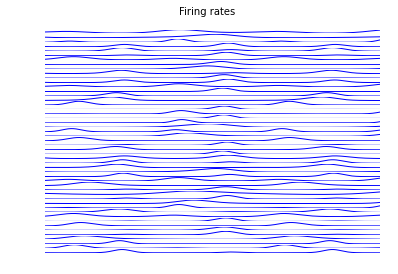

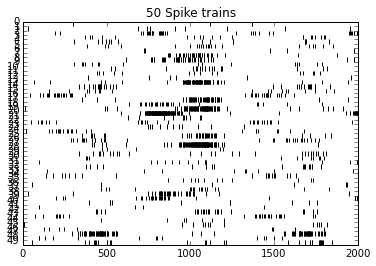

In [84]:
np.random.seed(0)

T = 2000
p = 0
L = 2
N = 50

high = np.log(25 / T)
low = np.log(5 / T)

# simulate latent processes
# x, ticks = simulation.latents(L, T, std, w)
x = np.empty((T, L), dtype=float)
# x[:T // 2, 0] = high
# x[T // 2:, 0] = low
# x[:, 1] = 2 * np.sin(np.linspace(0, 2 * np.pi * 5, T))
x[:, 0] = 2 * np.sin(0.005 * np.arange(T) + np.pi)
x[:, 1] = 2 * np.sin(0.01 * np.arange(T))

for l in range(L):
    x[:, l] -= np.mean(x[:, l])

# simulate spike trains
a = 2 * np.random.rand(L, N) - 1
for l in range(L):
    a[l, :] /= linalg.norm(a[l, :]) / np.sqrt(N)

b = np.empty((1 + p*N, N))
b[0, :] = low

y, _, rate = simulation.spikes(x, a, b, intercept=True)
figure()
_, ax = subplots(N, sharex=True)
for n in range(N):
    ax[n].plot(rate[:, n])
    ax[n].axis('off')
suptitle('Firing rates')

figure()
ylim(0, N)
for n in range(N):
    vlines(np.arange(T)[y[:, n] > 0], n, n + 1, color='black')
title('{} Spike trains'.format(N))
yticks(range(N))
gca().invert_yaxis()

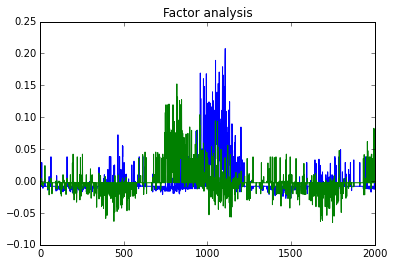

In [85]:
fa = FactorAnalysis(n_components=L)
m0 = fa.fit_transform(y)
a0 = fa.components_
# a0 = np.random.randn(L, N)
m0 *= np.linalg.norm(a0) / np.sqrt(N)
a0 /= np.linalg.norm(a0) / np.sqrt(N)

mu = np.zeros_like(x)

figure()
plot(m0)
title('Factor analysis')


Iteration[1]
lower bound = -46926.49891
increment = 327266.5328559055
time = 0.19s
change in alpha = 0.6265384370
change in beta = 0.9980044970
change in posterior mean = 1.0836471444
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
lower bound = -19146.48412
increment = 27780.0147889181
time = 0.18s
change in alpha = 1.2118902169
change in beta = 0.9957291373
change in posterior mean = 0.3707194578
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[3]
lower bound = -11348.88284
increment = 7797.6012800341
time = 0.19s
change in alpha = 0.7970184542
change in beta = 0.9855279484
change in posterior mean = 0.8407275409
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[4]
lower bound = -8839.92282
increment = 2508.9600198810
time = 0.20s
change in alpha = 0.7504659965
change in beta = 0.9610471922
change in posterior mean = 0.4738223295
change in prior variance = 0.000000

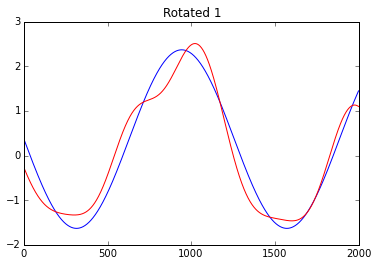

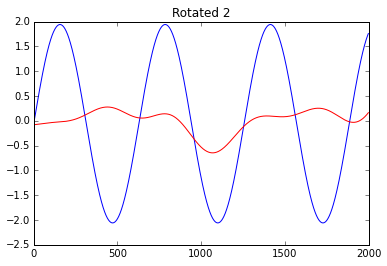

In [32]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-5
w[1] = 1e-4
m1 = None
lbound, m1, a1, b1, elapsed, converged = ichol_constrain_m.train(y, 0, var, w, b0=None, m0=m0, anorm=np.sqrt(N), hyper=False, kchol=100, niter=100, tol=1e-4, verbose=True)
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [33]:
var = np.empty(L, dtype=float)
var[0] = 5
var[1] = 5
w = np.empty(L, dtype=float)
w[0] = 1e-6
w[1] = 1e-5
m1 = None
lbound, m1, a1, b1, var1, w1, a0, b0, elapsed, converged = cov_stand_m.train(y, 0, var, w, a0=a0, b0=None, m0=m0, hyper=False, niter=100, tol=1e-4, verbose=True)
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

[ 7454.93945373  7453.45050568  7453.45050568 ...,  7392.57160163
  7474.81760433  7474.81760433]
[ 31988.62840126  31693.77967839  31693.77967839 ...,  28817.03017781
  29721.49215082  29721.49215082]

Iteration[1]
[ 9.71045189  9.70645297  9.70644993 ...,  9.65968841  9.6878152
  9.68781847]


KeyboardInterrupt: 

In [35]:
%lprun -f cov_stand_m.train cov_stand_m.train(y, 0, var, w, a0=a0, b0=None, m0=m0, hyper=False, niter=50, tol=1e-5, verbose=True)


Iteration[1]
lower bound = -46498.52239
increment = 2666077509.9416275024
time = 654.81s
change in alpha = 0.6588759557
change in beta = 0.9999975747
change in posterior mean = 1.0837158427
change in prior variance = 0.0000000000
change in prior scale = 0.0000000000

Iteration[2]
*** KeyboardInterrupt exception caught in code being profiled.

In [54]:
%lprun -f la.ichol_gauss la.ichol_gauss(3000, 1e-2, 1000)

In [45]:
hash(1e-6)

1599906073466377917

In [46]:
hash(1e-6)

1599906073466377917

In [48]:
la.ichol_gauss(230, 1e-2, 700)

/Users/yuan/variational/la.py:40: UserWarning: Not enough ranks
  warnings.warn('Not enough ranks')


array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.90049834e-01,   5.46024373e-09,  -2.13437566e-17, ...,
         -4.06024361e-17,   9.96766648e-23,   2.31288914e-20],
       [  9.60789439e-01,   1.80739112e-08,  -7.06498061e-17, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.23622704e-25,   5.90817484e-20,  -2.98363497e-22],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [56]:
chol_dict={}

In [57]:
chol_dict[hash(1e-2)] = la.ichol_gauss(T, 1e-2, 1000)

In [58]:
np.logspace(-6, -2, 5)

array([  1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
         1.00000000e-03,   1.00000000e-02])

In [59]:
for w in np.logspace(-6, -2, 5):
    chol_dict[hash(w)] = la.ichol_gauss(T, w, 1000)

In [60]:
chol_dict

{2305843009213694: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  9.99000500e-01,   2.22279381e-09,  -1.56901121e-17, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  9.96007989e-01,   5.13082952e-09,  -3.62171652e-17, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00]]),
 23058430092136940: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  9.90049834e-

In [73]:
chol = np.rollaxis(np.dstack((chol_dict[hash(1e-4)], chol_dict[hash(1e-5)])), 2)

In [74]:
chol.shape

(2, 2000, 1000)

In [64]:
chol_dict[hash(1e-4)].shape

(2000, 1000)

In [65]:
chol_dict[hash(1e-5)].shape

(2000, 1000)

In [80]:
np.array_equal(chol[0, :], chol_dict[hash(1e-4)])

True


Iteration[1]
lower bound = -46378.92592
increment = 1200605.5252002222
time = 9.41s
change in a = 0.7101589089
change in b = 0.9980039982
change in m = 1.0081380053


Iteration[2]
lower bound = -19209.47635
increment = 27169.4495707937
time = 9.12s
change in a = 1.4961526618
change in b = 0.9945860273
change in m = 0.2198713604


Iteration[3]
lower bound = -11098.46168
increment = 8111.0146639360
time = 9.37s
change in a = 0.7142189760
change in b = 0.9853608886
change in m = 0.2860068817


Iteration[4]
lower bound = -8567.74039
increment = 2530.7212938047
time = 8.96s
change in a = 0.8350230170
change in b = 0.9607984150
change in m = 0.4274644985


Iteration[5]
lower bound = -7767.26122
increment = 800.4791692975
time = 8.85s
change in a = 1.0745349022
change in b = 0.8980570510
change in m = 0.4022817017


Iteration[6]
lower bound = -7525.56084
increment = 241.7003811010
time = 8.79s
change in a = 0.6085411794
change in b = 0.7576447537
change in m = 0.0827039273


Iteration[7]
low

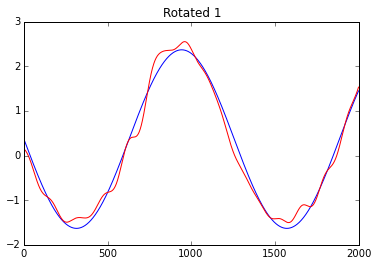

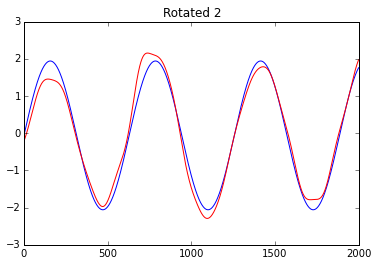

In [88]:
m1 = None
lbound, m1, a1, b1, elapsed, converged = ichol_constrain_m.train(y, 0, chol, a0=a0, b0=None, m0=m0, niter=100, tol=1e-4, verbose=True)
c = linalg.lstsq(m1, x)[0]
rotated = np.dot(m1, c)
for l in range(L):
    figure()
    plot(x[:, l] - np.mean(x[:, l]), label='latent', color='blue')
    plot(rotated[:, l], label='transformed posterior', color='red')
    title('Rotated {}'.format(l + 1))

In [87]:
chol.shape

(2, 2000, 1000)